<a href="https://colab.research.google.com/github/piushag/591NR/blob/dev-piusha/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.6 MB/s eta 0:00:00


In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from captum.attr import Saliency
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10


%matplotlib inline


from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [4]:
def move_image_right(image, num_pixels):
    # Pad the left side of the image with zeros
    pad = torch.zeros((3, num_pixels, 32))
    padded_image = torch.cat((pad, image), dim=1)
    # Crop the right side of the image to remove the padded pixels
    cropped_image = padded_image[:, :32, :]
    # Return the moved image
    return cropped_image

def move_image_left(image, num_pixels):
    # Get the width of the image
    width = image.shape[2]
    # Create a tensor of zeros with the same dimensions as the original image
    moved_image = torch.zeros_like(image)
    # Copy the pixels from the original image to the moved image with a leftward shift
    moved_image[:, :, :width-num_pixels] = image[:, :, num_pixels:]
    # Return the moved image
    return moved_image

def move_image_up(image, num_pixels):
    # Get the height of the image
    height = image.shape[1]
    # Create a tensor of zeros with the same dimensions as the original image
    moved_image = torch.zeros_like(image)
    # Copy the pixels from the original image to the moved image with an upward shift
    moved_image[:, :height-num_pixels, :] = image[:, num_pixels:, :]
    # Return the moved image
    return moved_image


def get_right_diff_channel(image):
    right_image = move_image_right(image,3)
    return torch.mean((image-right_image), dim=0, keepdim=True)

def get_left_diff_channel(image):
    left_image = move_image_left(image,3)
    return torch.mean((image-left_image), dim=0, keepdim=True)

def get_up_diff_channel(image):
    up_image = move_image_up(image,3)
    return torch.mean((image-up_image), dim=0, keepdim=True)

class AddNewChannels:
    """Add a fourth channel to the CIFAR-10 images with all zero values."""
    def __call__(self, img):
        return torch.cat((img, get_right_diff_channel(img), get_left_diff_channel(img), get_up_diff_channel(img)), dim=0)


Files already downloaded and verified
Files already downloaded and verified
[1,   100] loss: 3.237
[1,   200] loss: 3.001
[1,   300] loss: 2.752
[2,   100] loss: 2.584
[2,   200] loss: 2.505
[2,   300] loss: 2.467
[3,   100] loss: 2.424
[3,   200] loss: 2.350
[3,   300] loss: 2.352
[4,   100] loss: 2.288
[4,   200] loss: 2.295
[4,   300] loss: 2.269
[5,   100] loss: 2.239
[5,   200] loss: 2.179
[5,   300] loss: 2.162
[6,   100] loss: 2.120
[6,   200] loss: 2.109
[6,   300] loss: 2.085
[7,   100] loss: 2.060
[7,   200] loss: 2.100
[7,   300] loss: 2.030
[8,   100] loss: 2.055
[8,   200] loss: 2.026
[8,   300] loss: 1.985
[9,   100] loss: 2.009
[9,   200] loss: 2.011
[9,   300] loss: 1.936
[10,   100] loss: 1.997
[10,   200] loss: 1.967
[10,   300] loss: 1.879
Finished Training


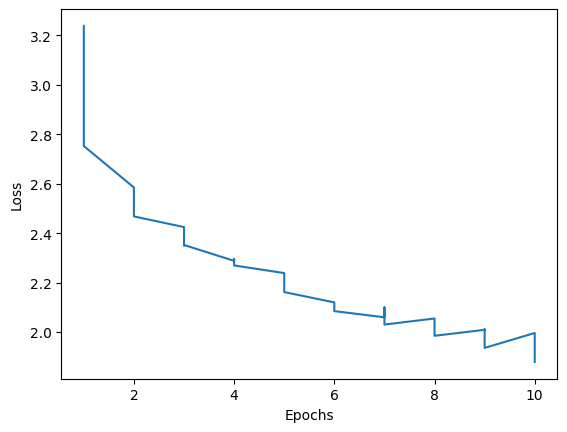

Accuracy of the SqueezeNet on the 10000 test images: 56 %


In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    AddNewChannels(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
])

# Define the transformations to be applied to the data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    AddNewChannels(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
])

# Load the CIFAR-10 dataset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Load a SqueezeNet model
net = torchvision.models.squeezenet1_1()

# Modify the first convolutional layer to accept 6 channels
net.features[0] = torch.nn.Conv2d(6, 64, kernel_size=3, stride=2)

# Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

import array

epochs = array.array('i')
losses = array.array('f')


for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            epochs.append(epoch+1)
            losses.append(running_loss/100)
            running_loss = 0.0

print('Finished Training')
plt.plot(epochs, losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.show()


# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the SqueezeNet on the 10000 test images: %d %%' % (100 * correct / total))


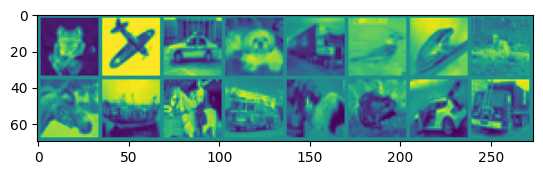

GroundTruth:   frog plane   car   dog truck  bird  frog  deer horse  ship horse truck   cat  frog   car truck
Predicted:    cat plane   car   dog truck plane  frog  frog horse  ship   dog   car   dog  frog truck truck


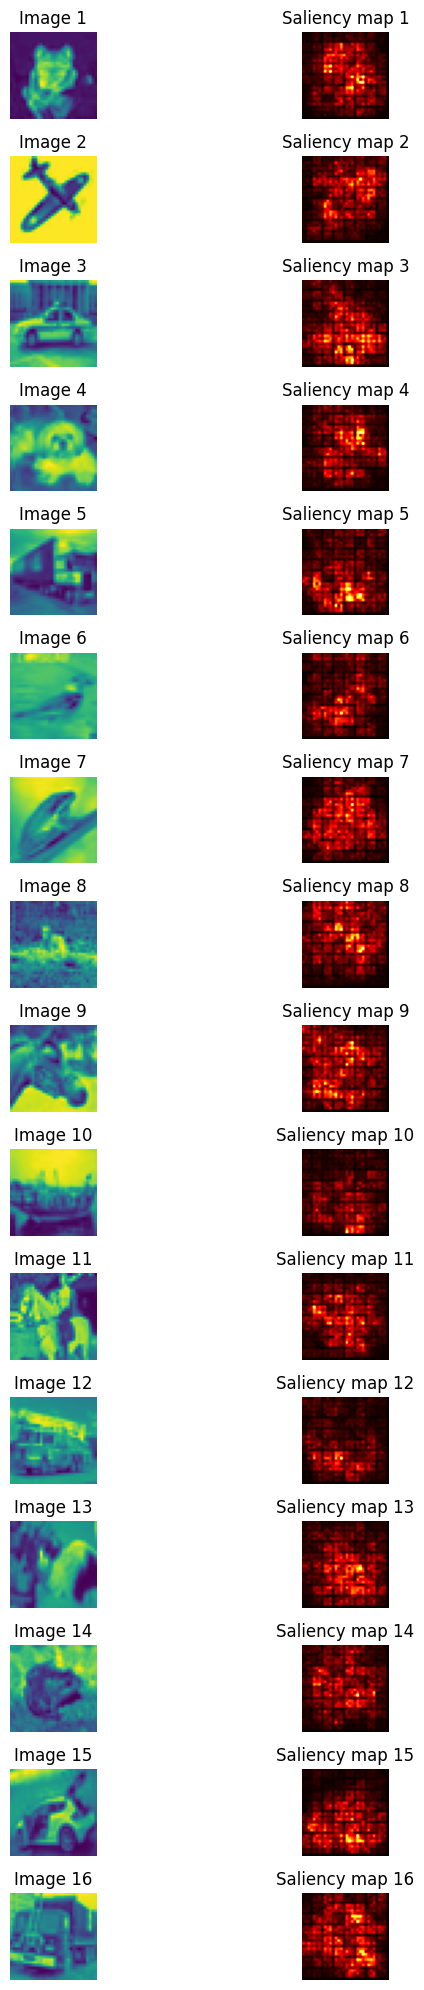

In [13]:
import random
import torch
import torch.nn.functional as F
from captum.attr import Saliency
import matplotlib.pyplot as plt

def imshow(img, transpose=True):
    img = img / 2 + 0.5     # unnormalize
    img = np.clip(img, 0, 1) # clip pixel values to [0,1]
    npimg = img.numpy()
    if transpose:
        npimg = np.transpose(npimg, (0, 2, 3, 1))  # transpose to (batch_size, height, width, channels)
    plt.imshow(npimg[0])
    plt.show()

dataiter = iter(testloader)
images, labels = next(dataiter)

# Select 16 random images
random_indices = random.sample(range(len(images)), k=16)
images = images[random_indices]
labels = labels[random_indices]


outputs = net(images)

_, predicted = torch.max(outputs, 1)

# Print images
imshow(torchvision.utils.make_grid(images), transpose=False)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(16)))

saliency = Saliency(net)


fig, axs = plt.subplots(nrows=len(images), ncols=2, figsize=(8, 20))
for i in range(len(images)):
    image = images[i].unsqueeze(0)
    npimg = image.numpy()
    npimg = npimg.squeeze()
    axs[i, 0].imshow(npimg[0], cmap='viridis')
    axs[i, 0].set_title(f"Image {i+1}")
    
    net.eval()
    image.requires_grad_()
    scores = net(image)

    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]

    score_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(),dim=1)
    axs[i, 1].imshow(saliency[0], cmap=plt.cm.hot)
    axs[i, 1].set_title(f"Saliency map {i+1}")
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()





In [14]:
# Define the adversarial attack
def fgsm_attack(image, epsilon, data_grad):
    # Calculate the sign of the gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adding the signed gradient to the original image
    perturbed_image = image + epsilon * sign_data_grad
    # Clip the perturbed image so that its pixel values are between 0 and 1
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [18]:
import torch.nn.functional as F

# Generate adversarial examples for the test dataset using FGSM attack
epsilon = 0.1
correct = 0
total = 0
for data in testloader:
    # Get the input image and label
    images, labels = data
    # Set requires_grad attribute of tensor to True, since we want to compute the gradient with respect to the input image
    images.requires_grad = True
    # Forward pass the input image through the model
    outputs = net(images)
    # Calculate the loss
    loss = F.cross_entropy(outputs, labels)
    # Zero out the gradients
    net.zero_grad()
    # Backward pass to compute the gradient
    loss.backward()
    # Get the gradient of the loss with respect to the input image
    data_grad = images.grad.data
    # Call the adversarial attack function to generate the perturbed image
    perturbed_image = fgsm_attack(images, epsilon, data_grad)
    outputs = net(perturbed_image)
    # Get the predicted label for the perturbed image
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Adversarial accuracy of the SqueezeNet on the 10000 test images: %d %%' % (100 * (correct) / total))

Adversarial accuracy of the SqueezeNet on the 10000 test images: 12 %
